In [1]:
import torch
import torch.nn as nn

# 先写一些最基础的卷积层

# group 相当于将in_channel均分为group份，每份分别卷积，相对于group=1的卷积，group=n卷积需要的卷积核参数是group=1的1/n，group=n的卷积核完全没有channel间的感受野
def conv3x3(in_channels, out_channels, stride=2, padding=1, groups=1):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding, groups=groups)

# conv1x1是另一个极端，完全没有channel内的感受野，但是也有很多应用，controlnet就是用conv1x1调参的
def conv1x1(in_channels, out_channels, stride=1, padding=0, groups=1):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding, groups=groups)

这张图来自resnet论文，我们来把这个结构复现出来，同时照着pytorch官方的实现，来提供一组易于拓展的resnet(想不到我居然会有一天在python里研究设计模式...)    
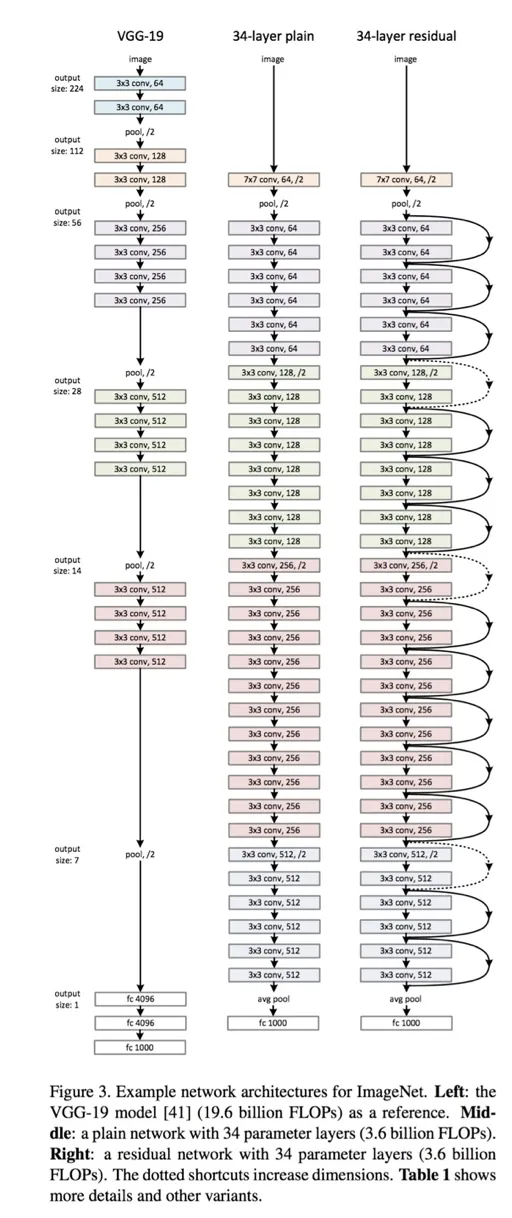  

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, channels, stride=1, basic_width=64, group=1, padding=1, norm_layer=None, downsample=None):
        super(BasicBlock, self).__init__() 
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(in_channels=in_channels, out_channels=channels, stride=stride)
        self.bn1 = norm_layer(in_channels=channels)
        # stride只会生效一次，我想主要是为了方便downsample层
        self.conv2 = conv3x3(in_channels=channels, out_channels=channels)
        self.bn2 = norm_layer(in_channels=channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identical = x # 存下来用来做残差
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)

        # 这里downsample的作用我的理解是：默认resnet是直接将identical加到输出里，不做什么变化，这样不会引入什么参数，但是啊，有时候block之间的channel数它变了，所以需要一个downsample层来把identical也变到目标channel
        if self.downsample is not None:
            identical = self.downsample(identical)
        
        return self.relu(x+identical)



basic block就是我们在上面的图里看到的结构，但是resnet比较厚的网络，使用的都是bottleneck来完成连接  

In [3]:
class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, channels, basic_width=64, stride=1, padding=1, groups=1, norm_layer=None, downsample=None):
        # 直观来看，bottleneck会对较大的输入和分出的group通过增加channel数量来补偿, 对于group总是要保证参数量和groups=1时一致，对于更大的图片，则按宽之比放缩参数量
        super().__init__()
        width = channels * ((int)(basic_width / 64)) * groups
        if norm_layer == None:
            norm_layer = nn.BatchNorm2d
        # TODO 我对这种设计的用心很好奇，看起来它们用两个conv1x1代替了 basicblock里的conv3x3，但是这么一来，单个block的通道内感知能力不是明显下降了么
        self.conv1 = conv1x1(in_channels=in_channels, out_channels=width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(in_channels=width, out_channels=width, groups=groups, stride=stride, padding=padding)
        self.bn2 = norm_layer(width)
        # TODO expansion... 看起来最后信息又全部被规约到一个与图像大小本身无关的恒定的大小了，感觉直觉上来讲的话，conv2用来确保即便图像大，对图像的理解也足够深（但是这水平感受野也没变啊...）conv3则要求不论图像多大，最后抽出来的信息量应当是符合channels参数的？？？
        self.conv3 = conv1x1(in_channels=width, out_channels=channels*self.expansion)
        self.bn3 = norm_layer(channels*self.expansion)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        # print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample != None:
            identity = self.downsample(identity)
        # TODO 为啥这里不过bnorm了啊？
        return self.relu(x+identity)



接下来我们实现resnet的主类

In [4]:
# 不带类型写起来真的太痛苦了
from typing import Union, Type, List


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        num_blocks: List[int],
        basic_width=64,
        norm_layer=None,
        groups=1,
        num_classes=1000,
    ):
        super().__init__()
        self.basic_width = basic_width
        self.groups = groups
        if norm_layer == None:
            self.norm_layer = nn.BatchNorm2d
        else:
            self.norm_layer = norm_layer
        # 威什么这个inchannel不能让用户自己定义呢...好像用户自己定一个数也不碍事啊
        self.in_channels = 64
        # 这里的卷积后size大小是 (size-7+6)/2+1 = size/2+0.5 pytorch的conv实现会自动向下取整，个人猜测就是直接放弃最后一次无法完成的卷积，而我们这个stride的余数反正只能是0,1，
        # 关于Maxpool2D和的反向传播法则可以看这两篇： 1.https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers 2.https://towardsdatascience.com/backpropagation-in-fully-convolutional-networks-fcns-1a13b75fb56a
        self.conv1_0 = nn.Conv2d(
            in_channels=3, out_channels=self.in_channels, kernel_size=7, padding=3
        )
        self.conv1_1 = nn.Conv2d(
            in_channels=3, out_channels=self.in_channels, kernel_size=5, padding=2
        )
        self.conv1_2 = nn.Conv2d(
            in_channels=3, out_channels=self.in_channels, kernel_size=9, padding=4
        )
        self.bn1 = self.norm_layer(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(
            block=block, channels=64, num_inside_layers=num_blocks[0]
        )
        self.layer2 = self._make_layer(
            block=block, channels=128, num_inside_layers=num_blocks[1], stride=2
        )
        self.layer3 = self._make_layer(
            block=block, channels=256, num_inside_layers=num_blocks[2], stride=2
        )
        self.layer4 = self._make_layer(
            block=block, channels=512, num_inside_layers=num_blocks[3], stride=2
        )
        # AdaptiveAvgPool 让我们不必单独再去设计核的大小，而是只需要设定下输出大小就好了 具体计算看这里，我有点不想去细究除不尽之类的话题了 https://stackoverflow.com/questions/58692476/what-is-adaptive-average-pooling-and-how-does-it-work/58694174#58694174
        # 这个pooling相当于每个channel，最后你就输出一个值啊
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 这个就是输出了
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 接下来就是权重参数的初始化了
        # 这里对卷积核的初始化采用了Kaiming Initialization https://paperswithcode.com/method/he-initialization，它会照着某种正太分布来初始化网络权重 TODO 进一步了解kaiming initialization
        # 这种初始化方式可以避免初始的参数连续指向某个增长方向甚至指数化放缩参数的情况，这可能导致网络很难训练
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # TODO 区分fan_in fan_out
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                # TODO batchnorm的过程有记不清了，主要是这两个权重是干啥的
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # TODO 这里还有一个经典的优化叫zero_init_residual 得去看看

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, BottleNeck]],
        channels,
        num_inside_layers,
        stride=1,
    ):
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_channels, channels * block.expansion, stride=stride),
                self.norm_layer(channels * block.expansion),
            )
        layers = []
        layers.append(
            block(
                in_channels=self.in_channels,
                channels=channels,
                basic_width=self.basic_width,
                stride=stride,
                padding=1,
                groups=self.groups,
                norm_layer=self.norm_layer,
                downsample=downsample,
            )
        )
        self.in_channels = channels * block.expansion
        for _ in range(1, num_inside_layers):
            layers.append(
                block(
                    in_channels=self.in_channels,
                    channels=channels,
                    groups=self.groups,
                    basic_width=self.basic_width,
                    norm_layer=self.norm_layer,
                )
            )
        return nn.Sequential(*layers)

    def forward(self, x):

        # print('forward start')
        # 随机从三种conv1中选择一个
        rand = torch.rand(1)
        if rand[0] < 0.33:
            x = self.conv1_0(x)
        elif rand[0] > 0.33 and rand[0] < 0.66:
            x = self.conv1_1(x)
        else:
            x = self.conv1_2(x)
        # x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # TODO 啊不是这都还没啥感受野啊，这就开始maxpool合适吗

        # print('to layer1')
        x = self.layer1(x)
        # print('to layer2')
        x = self.layer2(x)
        # print('to layer3')
        x = self.layer3(x)
        # print('to layer4')
        x = self.layer4(x)

        x = self.avgpool(x)
        # 将1*1的H*W的x拉成一条直的向量，也就成为了 (batch, num_class)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

接下来我们利用之前的类来构建一个基础的resnet50

In [5]:
# 为啥叫ResNet50，50层是怎么算的: 首先开始就有一个7*7卷积，num_layers是[3, 4, 6, 3]，也就是16个block，每个block是bottleneck，bottleneck有2个conv1*1和1个conv3*3，也就是48层，最后还有一个linear层，所以一起就是1+48+1=50
class resnet50(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model = ResNet(BottleNeck, [3, 4, 6, 3], num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

接下来我们来训练和测试这个模型，使用cifar100，并和官方模型的效果做一个比较

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


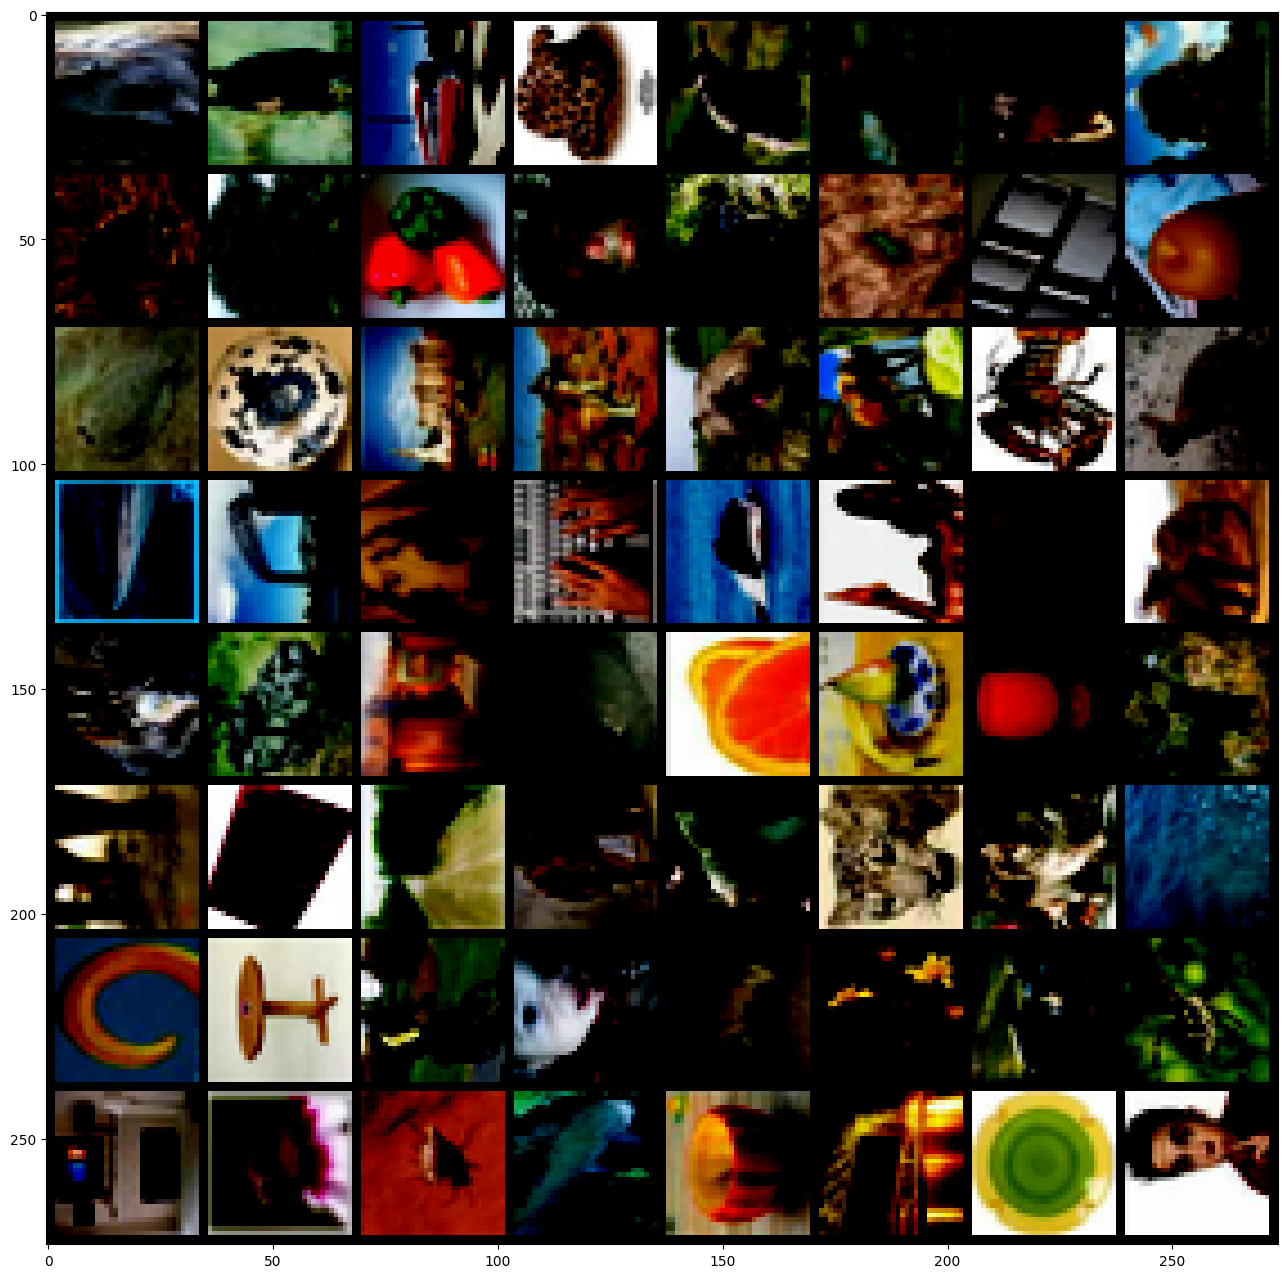

In [6]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

import torchvision.datasets as tvdata
import torchvision.utils as tvutil
import torchvision.transforms as transforms
import torch.utils.data as tdata
import matplotlib.pyplot as plt 
import numpy as np

# 这次试试normalize之后的表现
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# 做一些简单的数据扰动，省得模型自以为是
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32, padding=4, fill=128), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,.05), (0.5,0.5,0.5))])

trainset = tvdata.CIFAR100(root='./data', train=True, transform=transform, download=True)
testset = tvdata.CIFAR100(root='./data', train=False, transform=transform, download=True)

trainloader = tdata.DataLoader(dataset=trainset, batch_size=64, shuffle=True)
testloader = tdata.DataLoader(dataset=testset, batch_size=64, shuffle=False)

images, labels = next(iter(trainloader))
plt.figure(figsize=(16,16))
plt.imshow(np.transpose(tvutil.make_grid(images).cpu(), (2, 1, 0)))



训练

In [7]:
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

model = resnet50(num_classes=100)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

epochs = 50
writer = SummaryWriter(log_dir='./runs/kernel_random')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        batch, labels = data
        batch = batch.to(device)
        labels = labels.to(device)
        # 每轮开始前都要清零权重，否则之前的影响会叠加
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        print(f'training epoch: {epoch}, i: {i}')
        _, predict = torch.max(out, 1)
        total += labels.size()[0]
        correct += (predict == labels).sum().item()
        running_loss += loss.item()
        epoch_loss += loss.item()

        if i % 100 == 99:
            avg_loss = running_loss / 100
            running_loss = 0.0
            print(f'loss {avg_loss}')
    writer.add_scalar('Loss/Train', epoch_loss / total, epoch)
    writer.add_scalar('Accuarcy', correct / total, epoch)

    model.eval()

    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(testloader):
            batch, labels = data
            batch = batch.to(device)
            labels = labels.to(device)
            out = model(batch)
            _, predict = torch.max(out, 1)
            test_loss += criterion(out, labels)
            total += labels.size()[0]
            correct += (predict == labels).sum().item()

        print(f'test avg loss: {test_loss / len(testloader)}, accuracy: {correct / total:.2f}')
        writer.add_scalar('Test Accuarcy', correct / total, epoch)

model_path = './model_10.pth'
torch.save(model.state_dict(), model_path)


# model.eval()
# model.to(device)

# with torch.no_grad():
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     for i, data in enumerate(testloader):
#         batch, labels = data
#         out = model(batch)
#         test_loss += criterion(out, labels)
#         _, predict = torch.max(out, 1)
#         total += labels.size()[0]
#         correct += (predict == labels).sum().item()

#     print(f'test avg loss: {test_loss / len(testloader)}, accuracy: {correct / total:.2f}')


training epoch: 0, i: 0
training epoch: 0, i: 1
training epoch: 0, i: 2
training epoch: 0, i: 3
training epoch: 0, i: 4
training epoch: 0, i: 5
training epoch: 0, i: 6
training epoch: 0, i: 7
training epoch: 0, i: 8
training epoch: 0, i: 9
training epoch: 0, i: 10
training epoch: 0, i: 11
training epoch: 0, i: 12
training epoch: 0, i: 13
training epoch: 0, i: 14
training epoch: 0, i: 15
training epoch: 0, i: 16
training epoch: 0, i: 17
training epoch: 0, i: 18
training epoch: 0, i: 19
training epoch: 0, i: 20
training epoch: 0, i: 21
training epoch: 0, i: 22
training epoch: 0, i: 23
training epoch: 0, i: 24
training epoch: 0, i: 25
training epoch: 0, i: 26
training epoch: 0, i: 27
training epoch: 0, i: 28
training epoch: 0, i: 29
training epoch: 0, i: 30
training epoch: 0, i: 31
training epoch: 0, i: 32
training epoch: 0, i: 33
training epoch: 0, i: 34
training epoch: 0, i: 35
training epoch: 0, i: 36
training epoch: 0, i: 37
training epoch: 0, i: 38
training epoch: 0, i: 39
training e

测试保存的模型

In [8]:
model = resnet50(num_classes=100)
model.load_state_dict(torch.load('./model_10.pth', map_location=device, weights_only=True))
criterion = nn.CrossEntropyLoss()
model.to(device)
model.eval()

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(testloader):
        batch, labels = data
        batch = batch.to(device)
        labels = labels.to(device)
        out = model(batch)
        _, predict = torch.max(out, 1)
        test_loss += criterion(out, labels)
        total += labels.size()[0]
        correct += (predict == labels).sum().item()

    print(f'test avg loss: {test_loss / len(testloader)}, accuracy: {correct / total:.2f}')

test avg loss: 5.5009331703186035, accuracy: 0.37
